In [1]:
#### load packages, *.h5 folder and exp.h5 file location
%matplotlib widget

from essential_func import *
from analysis_data import *

qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])

default_sample_dir = 'Mar-2023-Sample#1948'  #'July-sorted'  # '20-Dec' # 'July-2021-Sample#6'
csv_and_code_abs_directory = '/Users/bashit.a/Documents/Alzheimer/Codes/'
samples_csv = 'data_directory.csv'

dropdown_name, dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = default_sample_dir, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)

Python directory is set to load samples from : Mar-2023-Sample#1948


embedding dim is  90
Frames : contains 3844 samples


interactive(children=(Select(description='model', layout=Layout(height='auto', width='50%'), options=('model_4…

<function __main__.plot_heatmap(model_name, thr)>

Output()

viewing file 1971_V1-roi0_0_0_masked.h5
Layer (type:depth-idx)                   Output Shape              Param #
├─OutputFeedForward: 1-1                 [-1, 2]                   --
|    └─Conv1d: 2-1                       [-1, 1, 82]               6
|    └─LeakyReLU: 2-2                    [-1, 1, 82]               --
|    └─Linear: 2-3                       [-1, 2]                   166
|    └─LeakyReLU: 2-4                    [-1, 2]                   --
|    └─Dropout: 2-5                      [-1, 2]                   --
|    └─Linear: 2-6                       [-1, 2]                   6
Total params: 178
Trainable params: 178
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


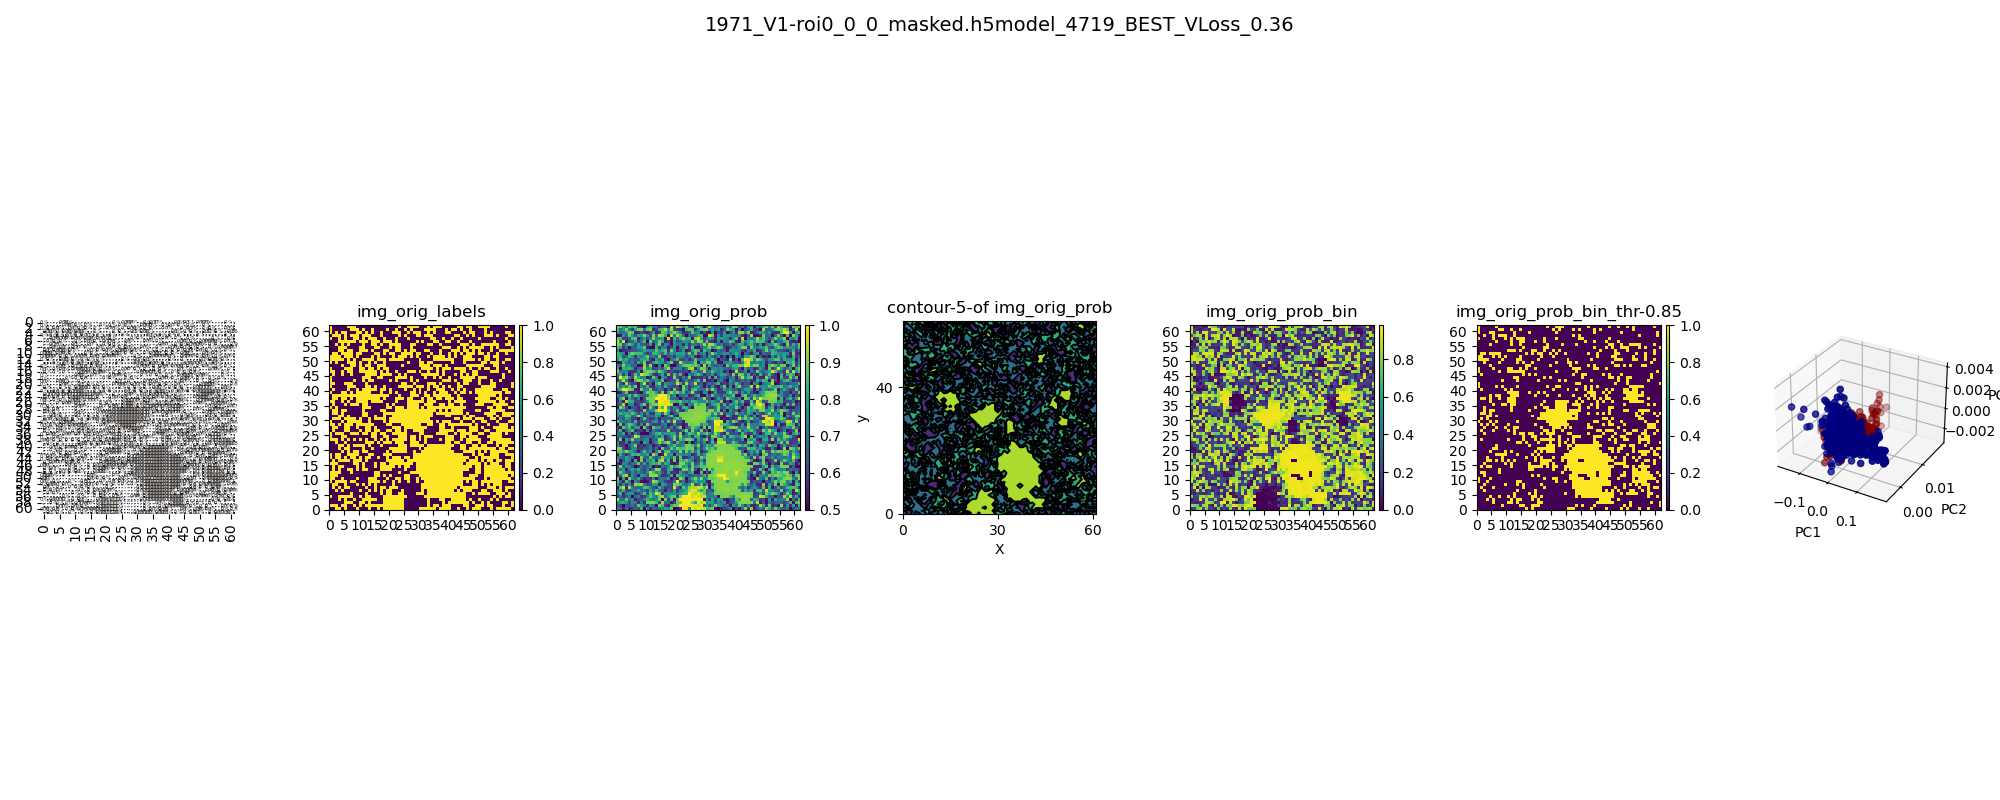

In [16]:
### model prediction

%matplotlib widget
import torch, sys, yaml
sys.setrecursionlimit(10000)
from torchsummary import summary
from sklearn.decomposition import PCA

### parameters
input_params      = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/dataloader/lesions.yaml"     # lesion location required for Iq data
model_params      = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/models/transformer.yaml"     # nn_model configuration
model_arch_path   = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/models"                      # python code location
model_loc         = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/runs"  # model location
dataloader_path   = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/dataloader"
BNL_dir           = "/Volumes/HDD/BNL-Data/Mar-2023"    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir           = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV

Excel_file        = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated.xlsx"
sheet             = 'Mar-2023-Samples'


input_file        = "1971_V1-roi0_0_0_masked.h5" # "1971_Hippo-roi0_0_0_masked_intp.h5" - (61,62)    "1948_PHG-roi0_0_0_masked.h5"  - (62,122)  "1971_Hippo-roi1_0_0_masked_intp.h5" - (62,61)  "2068_PHG_2-roi0_0_0_masked_intp.h5" - (42,42) "1898_CING-roi0_0_0_masked_intp.h5" - (41,41)
input_file_loc    = f'/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/{input_file}_merged.csv' # '/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948 V1-roi0_0_0_masked.h5_merged.csv'
input_width_height= (62,62)     # (62,61)

mica_sub          = True
# file              = open("/Users/bashit.a/Documents/Alzheimer/Codes/ML/main/mica_bkg", "rb")  # Open the file in read binary mode
# mica_Iq           = np.load(file)      # Read the file to numpy array
# file.close   
scaling           = False
tissue_sub        = False
column_names      = {"Frames":100}       ### Dummy column


level             = 5 # contour level

class model_prediction(object):

    def __init__(self, qgrid2, input_params, model_params, model_arch_path):

        self.qgrid           = qgrid2
        self.input_params    = input_params
        self.model_params    = model_params
        self.model_arch_path = model_arch_path

        ### import packages and model
        sys.path.insert(0, self.model_arch_path)
        from Transformer import Transformer

        self.Transformer = Transformer
        ### set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

        ### load input parameters from yaml file
        with open(self.input_params) as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
        self.q_min, self.q_max = config["parameters"]["qvalue_lower_bound"]["value"], config["parameters"]["qvalue_upper_bound"]["value"]
        self.lidx = np.argmin(qgrid2 < self.q_min)   # qvalue = 0.7,  idx = 190
        self.uidx = np.argmin(qgrid2 < self.q_max)   # qvalue = 1.46, idx = 342
        self.input_dim = (self.uidx-self.lidx)
        self.column_names = config["parameters"]["column_names"]["value"]       # classifier - {"Diffuse_Plaque":1., "Tissue":0.}
        self.n_classes = len(np.unique(list(self.column_names.values())))

        ### load model parameters from yaml file
        with open(self.model_params) as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
        config = config["parameters"]
        self.n_heads        = config["n_heads"]["value"]
        self.hidden_dim     = config["hidden_dim"]["value"]
        self.N              = config["N"]["value"]
        self.dropout        = config["dropout"]["value"]
        self.seq_len        = config["seq_len"]["value"]
        assert self.input_dim%self.seq_len ==0 , f'q value range is not divisible by {seq_len} '
        self.embedding_dim  = self.input_dim//self.seq_len

        self.model = self.Transformer(self.n_heads, self.seq_len, self.embedding_dim, self.hidden_dim, self.N, self.dropout, self.n_classes)

    def load_data(self, input_file, input_file_loc, input_width_height, column_names, dataloader_path, excel_file, sheet, BNL_dir, sub_dir, mica_sub, scaling, tissue_sub):

        self.input_file  = input_file
        self.excel_file  = excel_file
        self.sheet       = sheet
        self.BNL_dir     = BNL_dir
        self.sub_dir     = sub_dir

        df = pd.DataFrame([None],dtype=str)
        df["File"] = None
        df["File_Loc"] = None
        df["Frames"] = None
        # df["Tissue"] = str(tissue_fr)
        idx = 0
        df.at[idx, "File"] = input_file
        df.at[idx, "File_Loc"] = input_file_loc
        self.Width, self.Height = input_width_height
        df.at[idx, "Frames"] = str(np.arange(0, self.Width*self.Height,dtype=int).tolist())

        sys.path.insert(0, dataloader_path)
        from lesions import get_dataframe_with_files_loc, XrayData
        
        df['bkg_model'] = None
        df_bkg = get_dataframe_with_files_loc(excel_file, sheet, BNL_dir, sub_dir)
        bkg_frames = df_bkg[df_bkg['File'] == input_file].iloc[0]['bkg_model']
        df.at[idx, 'bkg_model'] = bkg_frames
        
        ### get tissue frames
        df["Tissue"] = None
        tissue_frames = df_bkg[df_bkg['File'] == input_file].iloc[0]['bkg_model']
        df.at[idx, 'Tissue'] = tissue_frames
        
        self.df = df

        self.dataset     = XrayData(self.df, column_names, BNL_dir, sub_dir, lidx=self.lidx, uidx=self.uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub).x
        self.Iq          = torch.tensor(self.dataset, dtype=torch.float32).to(self.device)

        ### PCA calculation
        pca = PCA(n_components=3)
        pca.fit(self.Iq)
        self.Iq_PCA = pca.transform(self.Iq)

    def load_model(self, model_loc):
        print(f'loading model : {model_loc}')
        self.model_loc = model_loc

        self.model.load_state_dict(torch.load(model_loc, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

        self.newRange = {}
        for i in range(self.n_classes):
            self.newRange[i] = (i/self.n_classes, (i+1)/self.n_classes)

    def inference(self, thr):

        frames = np.arange(0, self.Width*self.Height)

        self.y_pred = self.model(self.Iq[frames], None)
        self.y_pred_softmax = torch.round(torch.nn.functional.softmax(self.y_pred, dim=1), decimals=4)

        self.y_pred_labels = torch.argmax(self.y_pred, 1).type(torch.int)
        self.y_pred_prob   = torch.round(self.y_pred_softmax[np.arange(0, len(self.y_pred)), self.y_pred_labels], decimals=4)
        # print(f'minimum prob: {self.y_pred_prob.min():0.4f} and maximum prob {self.y_pred_prob.max():0.4f}')
        
        self.img_orig_labels  = snaking(self.Width, self.Height, self.y_pred_labels.detach().numpy())
        self.img_orig_prob    = snaking(self.Width, self.Height, self.y_pred_prob.detach().numpy() )

        diff_patterns = []
        for frame, label in enumerate(self.y_pred_labels.detach().numpy()):
            newMin, newMax  = self.newRange[label]
            prob = self.translate_range( self.y_pred_prob[frame].detach().numpy(), newMin=newMin, newMax=newMax)
            diff_patterns.append(prob if label else newMax-prob)
        self.diff_patterns = np.array(diff_patterns)
        
        ### masking out background
        # df_bkg = get_dataframe_with_files_loc(self.excel_file, self.sheet, self.BNL_dir, self.sub_dir)
        column_name = 'bkg_model'
        frames_bkg = eval(self.df[self.df['File'] == self.input_file][column_name].tolist()[0])
        if isinstance(frames_bkg, list):
            self.diff_patterns[frames_bkg] = 0
            
        self.diff_patterns_thr = self.diff_patterns > thr
        self.img_orig_prob_bin     = snaking(self.Width, self.Height, self.diff_patterns)
        self.img_orig_prob_bin_thr = snaking(self.Width, self.Height, self.diff_patterns_thr)
    
    @staticmethod
    def translate_range(x, xmin = 0, xmax = 1 , newMin = 0, newMax = 0.33):
        return round(( (x-xmin)/(xmax-xmin) )* (newMax-newMin) + newMin,2)

    def plot_pca(self, ax):
        ax.scatter(self.Iq_PCA[:,0],self.Iq_PCA[:,1],self.Iq_PCA[:,2], c=self.diff_patterns_thr, cmap='jet')
        ax.set_xlabel("PC1", fontsize=10)
        ax.set_ylabel("PC2", fontsize=10)
        ax.set_zlabel("PC3", fontsize=10)     

import seaborn as sns
plt.close('all')
nrows = 1
ncols = 7
from mpl_toolkits.mplot3d import axes3d

# f, axs = plt.subplots(ncols=ncols, nrows = nrows, figsize=(20,6))
f = plt.figure(figsize=(20,8))
axs = [f.add_subplot(nrows, ncols,1), f.add_subplot(nrows, ncols,2), f.add_subplot(nrows, ncols,3), f.add_subplot(nrows, ncols,4), f.add_subplot(nrows, ncols,5), f.add_subplot(nrows, ncols,6), f.add_subplot(nrows, ncols,7, projection='3d')] # 

out    = model_prediction(qgrid2, input_params, model_params, model_arch_path)
out.load_data(input_file, input_file_loc, input_width_height, column_names, dataloader_path, Excel_file, sheet, BNL_dir, sub_dir, mica_sub, scaling, tissue_sub)

out_w = ipywidgets.Output()

@out_w.capture(clear_output=True)
def plot_heatmap(model_name, thr):


    out.load_model(os.path.join(model_loc, model_name))
    out.inference(thr)

    print(np.where(out.diff_patterns > thr)[0].tolist())

    axs[0].clear(), axs[1].clear(), axs[2].clear(), axs[3].clear(), axs[4].clear(), axs[5].clear(), axs[6].clear()
    while len(f.axes) >nrows*ncols:
        f.axes[-1].remove()

    sns.heatmap(out.img_orig_labels, annot=out.img_orig_prob,  linewidth=.5, fmt=".1f", annot_kws={"fontsize":4}, ax=axs[0], square=True, cbar=False, cbar_kws={"shrink": .5})
    plot_heat_map_from_data(out.img_orig_labels, out.Width, out.Height, args = (f,axs[1]), title= "img_orig_labels", cmap="viridis")
    plot_heat_map_from_data(out.img_orig_prob, out.Width, out.Height, args = (f,axs[2]), title= "img_orig_prob", cmap="viridis")

    ## contour plot
    try:
        us = np.linspace(np.min(out.img_orig_prob), np.max(out.img_orig_prob), level, endpoint=True) # For Manual selection of colour bar
        cf = axs[3].contourf(np.arange(0, out.Width, 1), np.arange(0,out.Height,1), np.flip(out.img_orig_prob,0), us, origin='lower', cmap='viridis', )
        axs[3].contour(np.arange(0, out.Width, 1), np.arange(0,out.Height,1), np.flip(out.img_orig_prob,0), us, colors='k') # For plotting only contours
        axs[3].set_aspect('equal')    
        axs[3].set(title = f'contour-{level}-of img_orig_prob', xlabel = 'X' , ylabel = 'y', xscale='linear', yscale ='linear' , xticks = np.arange(0 , out.Width,30), yticks=np.arange(0, out.Height, 40))
    except:
        pass
    
    plot_heat_map_from_data(out.img_orig_prob_bin, out.Width, out.Height, args = (f,axs[4]), title= "img_orig_prob_bin", cmap="viridis")
    plot_heat_map_from_data(out.img_orig_prob_bin_thr, out.Width, out.Height, args = (f,axs[5]), title= f'img_orig_prob_bin_thr-{thr}', cmap="viridis")
    out.plot_pca(axs[6])
    f.suptitle(input_file+model_name, fontsize=14)
    plt.tight_layout()

files = sorted((cwd_files_search_with(seek_str="model", search_where="start", directory = model_loc)), key=lambda x: int(x.split('_')[1]))
model_widget = ipywidgets.Select(options= files , description="model", continuous_update=False,  layout=ipywidgets.Layout(height="auto", width="50%"))
thr_widget = ipywidgets.FloatSlider(value=0.85, min=0, max=1, step=0.01, continuous_update=False, description="thr", disabled=False, layout=ipywidgets.Layout(height="auto", width="50%"))
output = ipywidgets.interact(plot_heatmap,  model_name=model_widget, thr=thr_widget)
display(output)
display(out_w)
print(f'viewing file {input_file}')
summary(out.model, [1,out.input_dim], None)
pass

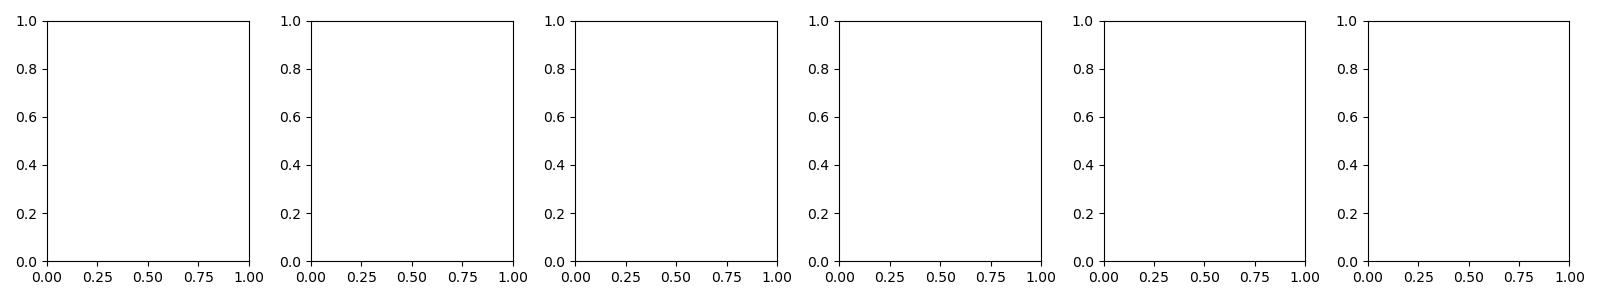

interactive(children=(SelectionSlider(continuous_update=False, description='Frame', layout=Layout(width='50%')…

In [4]:
### visualizing model layers
%matplotlib widget
from functools import partial

class FeatureExtractor:
    def __init__(self):
        self.extracted_features = dict()
    def extract_features(self, module, input_, output, name):
        self.extracted_features[name] = output
    def get_extracted_features(self, name):
        return partial(self.extract_features, name=name)

return_layers = { 
                  # 'layer1': out.model.model.layer1,
                  # 'act1':   out.model.model.act1,
                  'layer2': out.model.model.layer2,
                  'act2':   out.model.model.act2,
                  'layer3': out.model.model.layer3,
                  'act3':   out.model.model.act3,
                  'layer4': out.model.model.layer4}


extractor = FeatureExtractor()
for name, layer in return_layers.items():
    layer.register_forward_hook(extractor.get_extracted_features(name))
out.model(out.Iq, None)

plt.close()
f, axs = plt.subplots(nrows=1, ncols=len(return_layers.keys())+1,figsize=(16,3))
def show_plot(frame):
    [ax.clear() for ax in axs]
    print(frame)
    axs[0].plot(out.Iq[frame])
    axs[0].set_title(f'input-frame-{frame}')
    for idx, (name, _) in enumerate(return_layers.items()):
        x = extractor.extracted_features[name].detach().numpy()[frame]
        axs[idx+1].plot( x.T if x.shape[0]!=1 else x.ravel() )
        axs[idx+1].set_title(name)
plt.tight_layout()
plt.show()

#[56, 57, 58, 59, 60, 61, 62, 63, 87, 95, 233, 276, 294, 295, 296, 353, 359, 360, 361, 362, 363, 373, 375, 377, 378, 379, 380, 525, 697, 819, 908, 909, 1003, 1045, 1046, 1047, 1087, 1125, 1170, 1171, 1205, 1206, 1368, 1520] 
options = [72, 169, 170, 171, 172, 186, 187, 194, 195, 196, 290, 291, 298, 299, 300, 301, 308, 309, 310, 311, 316, 420, 421, 422, 423, 430, 431, 449, 777, 850, 851, 879, 947, 949, 951, 1001, 1003, 1004, 1069, 1070, 1071, 1414, 1448, 1449, 1626, 1667, 2051, 2096, 2097, 2098, 2171, 2576, 2577, 2666, 2667, 2668, 2669, 2670, 2698, 2699, 2700, 2789, 2790, 2791, 2792, 3175, 3290, 3291, 3294, 3415, 3416, 3520]
 # np.arange(0, (out.Width*out.Height), 1)  # np.arange(0, (out.Width*out.Height), 1)

frame = ipywidgets.SelectionSlider(value=options[0], options=options, description = 'Frame', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
output = ipywidgets.interactive(show_plot, frame=frame)
display(output)

In [ ]:
#### create heamaps in pdf from runs/models
%matplotlib widget

### spec
thr = 0.9

pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(model_loc,f'{input_file}-model-preds.pdf'))
for model_name in files:
    plt.close('all')
    f, ax = plt.subplots()
    out.load_model(os.path.join(model_loc,model_name))
    out.inference(thr)
    plot_heat_map_from_data(out.img_orig_prob_bin, out.Width, out.Height, args = (f,ax), title= model_name, cmap="viridis")
    pdf.savefig(f);   #f.savefig("foo.pdf", ) 
pdf.close();
plt.close('all')

In [ ]:
# Export model to onnx format
import onnx
torch_input = (out.Iq, None)
torch.onnx.export(out.model, torch_input, os.path.join(model_loc,"Inference_Model.onnx"))
print(f'model saved on {model_loc}')

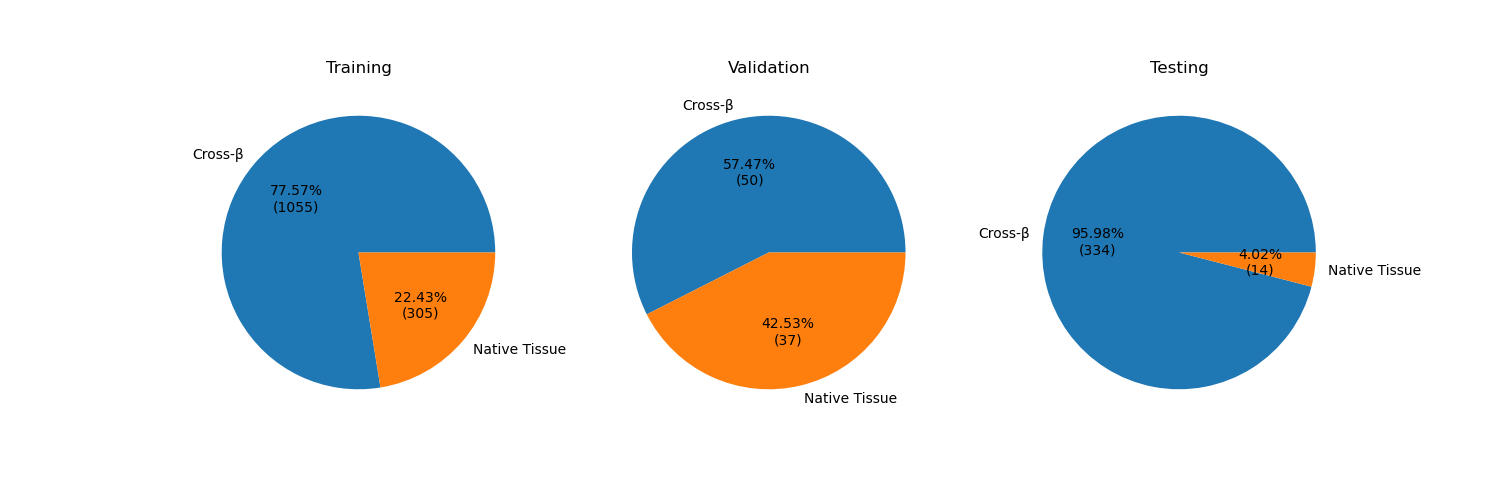

In [84]:
### Pie-plot for training data distribution for shallow neural network
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
plt.close('all')
def absolute_value(val):
    return f"{val:.2f}%\n({int(round(val * total / 100.0)):.0f})"

# Data
training_data   = [1055, 305]
validation_data = [50, 37]
testing_data    = [334, 14]

labels = [f'Cross-β', 'Native Tissue']

# Create a figure and axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Training Pie Chart
total = sum(training_data)
ax[0].pie(training_data, labels=labels, autopct=absolute_value)
ax[0].set_title('Training')

# Validation Pie Chart
total = sum(validation_data)
ax[1].pie(validation_data, labels=labels, autopct=absolute_value)
ax[1].set_title('Validation')

# Testing Pie Chart
total = sum(testing_data)
ax[2].pie(testing_data, labels=labels, autopct=absolute_value)
ax[2].set_title('Testing')

# Save the figure
plt.show()
plt.tight_layout()
plt.savefig("/Users/bashit.a/Documents/Alzheimer/Codes/dataset_pie.png", format='png', dpi=600, transparent=True)

current recursion limit set to: 10000
Tissue : contains 356 samples
Diffuse_Plaque : contains 68 samples
Neurofibrillary_Tangle_(tau) : contains 67 samples
Tau : contains 8 samples
Neuritic_Plaque : contains 1304 samples


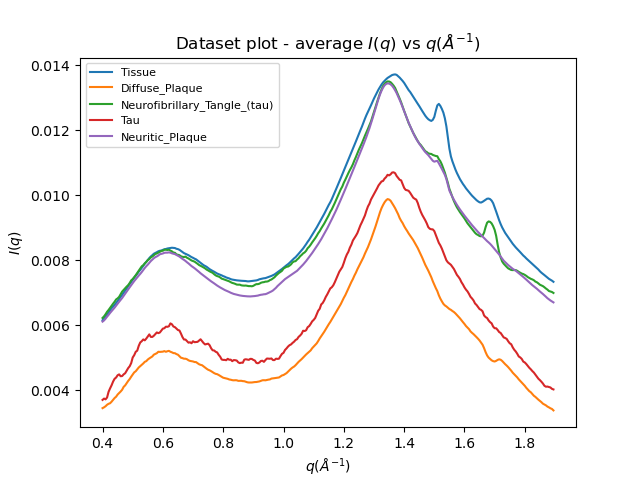

In [2]:
### Dataset visualizing - on average
import sys, os, inspect, glob, h5py, json,copy

parentdir  = '/Users/bashit.a/Documents/Alzheimer/Codes/ML'
sys.path.insert(0, os.path.join(parentdir, 'dataloader'))
sys.path.insert(0, os.path.join(parentdir, 'models'))

from lesions import *
qvalue_lower_bound = 0.4
qvalue_upper_bound = 1.9
qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])
lidx = np.argmin(qgrid2 < qvalue_lower_bound)   # qvalue = 0.7,  idx = 190
uidx = np.argmin(qgrid2 < qvalue_upper_bound)   # qvalue = 1.46, idx = 342

column_names =  {"Tissue":0., "Diffuse_Plaque":1., "Neurofibrillary_Tangle_(tau)":2. , "Tau":3. ,"Neuritic_Plaque":4. }     # {"Diffuse_Plaque":0., "Neurofibrillary_Tangle_(tau)":1. , "Tau":2. ,"Neuritic_Plaque":3., "Tissue":4., "bkg":5.0 }
Excel_File   = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated.xlsx"   # "/home/bashit.a/Codes/ML/Mar-2023-Samples.xlsx"   "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples.xlsx"    sheet       = 'Mar-2023-Samples'
BNL_dir      = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir      = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV
val_files    = ["1898_CING-roi0_0_0_masked_intp.h5"] # None ["1948_HIPPO-roi1_0_0_masked_intp.h5", "2428-roi1_0_0_masked_intp.h5"]
sheet        = 'Mar-2023-Samples'

df      = get_dataframe_with_files_loc(Excel_File, sheet, BNL_dir, sub_dir)
dataset = XrayData(df, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx)

plt.close('all')
plt.subplots()
for (k,v) in column_names.items():
    plt.plot(qgrid2[lidx:uidx], dataset.x[np.where(dataset.y==v)[0]].mean(axis=0),label=k)
plt.legend(fontsize=8)
plt.xlabel('$q(\AA^{-1})$')
plt.ylabel('$I(q)$')
plt.title('Dataset plot - average $I(q)$ vs $q(\AA^{-1})$')
plt.show()

In [57]:
### best model - just copyed the model
class OutputFeedForward(nn.Module):

    def __init__(self, input_dim, dropout, n_classes):
        super().__init__()
        in_channels = 1
        # self.layer1 = nn.Conv1d(in_channels, 16, kernel_size=1, padding=0, dilation=1, stride=1, bias=True)
        # self.act1   = nn.LeakyReLU(0.01)
        kernel_size = 5
        padding     = 0
        dilation    = 2
        stride      = 1
        self.layer2     = nn.Conv1d(in_channels, 1, kernel_size=kernel_size, padding=padding, dilation=dilation, stride=stride, bias=True)
        self.layer2_dim = (input_dim + 2*padding - dilation*(kernel_size-1) - 1)//stride + 1 
        self.act2       = nn.LeakyReLU(0.01) # nn.ReLU() # nn.LeakyReLU(0.01)
        # print(self.layer2_dim)
        # self.feature  = nn.Linear(self.layer2_dim, self.layer2_dim, bias=False)
        # self.const    = torch.diag( torch.ones(self.layer2_dim) )
        # self.feature.weight = nn.Parameter(self.const)

        self.layer3  = nn.Linear(self.layer2_dim, 2) # self.layer2_dim   input_dim
        self.act3    = nn.LeakyReLU(0.01) # nn.ReLU() # nn.LeakyReLU(0.01) 
        self.dropout = nn.Dropout(dropout)
        self.layer4  = nn.Linear(2,n_classes)
        # self.layer4  = nn.Linear(self.layer2_dim,n_classes)

    def forward(self,x):
        # x      = self.act1(self.layer1(x))
        x      = self.act2(self.layer2(x))
        
        # self.feature.weight.data.mul_(self.const)
        # x      = self.feature(x)

        x      = x.view(-1,x.size()[-1])
        x      = self.dropout(self.act3(self.layer3(x)))
        x      = self.layer4(x)
        return x

model = OutputFeedForward(90,0.02, 2)
summary(model, [1,90])

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 1, 82]               6
├─LeakyReLU: 1-2                         [-1, 1, 82]               --
├─Linear: 1-3                            [-1, 2]                   166
├─LeakyReLU: 1-4                         [-1, 2]                   --
├─Dropout: 1-5                           [-1, 2]                   --
├─Linear: 1-6                            [-1, 2]                   6
Total params: 178
Trainable params: 178
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 1, 82]               6
├─LeakyReLU: 1-2                         [-1, 1, 82]               --
├─Linear: 1-3                            [-1, 2]                   166
├─LeakyReLU: 1-4                         [-1, 2]                   --
├─Dropout: 1-5                           [-1, 2]                   --
├─Linear: 1-6                            [-1, 2]                   6
Total params: 178
Trainable params: 178
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [10]:
# testing weighted_balanced_accuracy
import torch

def weighted_balanced_accuracy(y_pred, y_true, weights):
    """
    Calculate weighted balanced accuracy.

    Parameters:
    y_pred (torch.Tensor): Predicted labels.
    y_true (torch.Tensor): True labels.
    weights (torch.Tensor): Sample weights.

    Returns:
    balanced_accuracy (float): Weighted balanced accuracy.
    """
    y_pred = y_pred.long()
    y_true = y_true.long()
    # Normalize weights
    weights = weights / weights.sum()

    # Create a tensor with weights for each true label
    weights = torch.tensor([weights[label.item()] for label in y_true])

    # Get unique classes
    classes = torch.unique(y_true)

    weighted_recalls = []

    for cls in classes:
        # Mask for true class
        true_class_mask = (y_true == cls)

        # Calculate true positives and false negatives
        tp = torch.sum(torch.logical_and(y_true == cls, y_pred == cls) * weights)
        fn = torch.sum(torch.logical_and(y_true == cls, y_pred != cls) * weights)

        # Calculate recall
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Calculate weighted recall
        weighted_recall = torch.sum(weights[true_class_mask]) * recall
        weighted_recalls.append(weighted_recall)

    # Calculate weighted sum
    weighted_sum = torch.sum(weights)

    # Calculate balanced accuracy
    balanced_accuracy = torch.sum(torch.tensor(weighted_recalls)) / weighted_sum
    return balanced_accuracy

y_true = torch.tensor([1, 0, 0],dtype=torch.float32)
y_pred = torch.tensor([[0], [0], [0]],dtype=torch.float32)
weights = torch.tensor([2.23, 0.64], dtype=torch.float32)

balanced_acc = weighted_balanced_accuracy(y_pred, y_true, weights)
print("Weighted Balanced Accuracy:", balanced_acc)

Weighted Balanced Accuracy: tensor(0.8745)


Setting Training Dataset ...
Neuritic_Plaque : contains 1280 samples
Diffuse_Plaque : contains 26 samples
Neurofibrillary_Tangle_(tau) : contains 67 samples
Tissue : contains 317 samples
Setting Validation Dataset ...
Neuritic_Plaque : contains 24 samples
Diffuse_Plaque : contains 3 samples
Tissue : contains 6 samples
Setting Testing Dataset ...
Diffuse_Plaque : contains 39 samples
Tissue : contains 33 samples
['weight 0 : 2.67 ', 'weight 1 : 0.62 ']
training_loader size : 1 ; validation_loader size : 1 ; testing_loader size : 1
<class 'torch.Tensor'> torch.float32 torch.Size([1690, 90]) torch.Size([1690, 1]) torch.float32 1


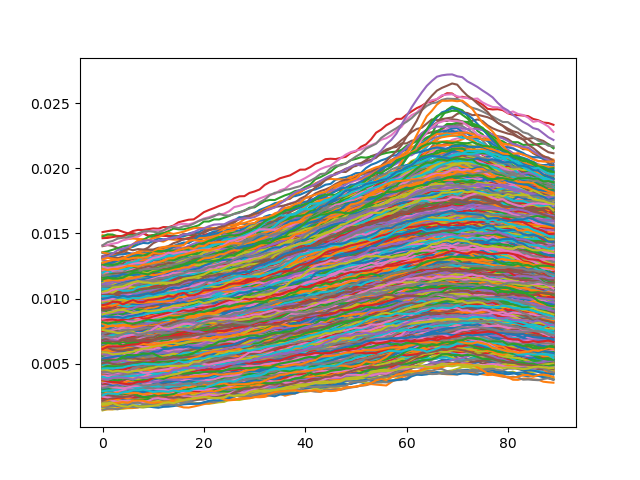

In [40]:
### code testing - to load training data, val data, and test data
import sys, os, inspect, glob, h5py, json,copy

parentdir  = '/Users/bashit.a/Documents/Alzheimer/Codes/ML'
sys.path.insert(0, os.path.join(parentdir, 'dataloader'))
sys.path.insert(0, os.path.join(parentdir, 'models'))
from lesions import *

lidx = 250
uidx = 340
column_names= {"Neuritic_Plaque":1., "Diffuse_Plaque":1., "Neurofibrillary_Tangle_(tau)":1., "Tissue":0.}   # "Tau":1., "Neuritic_Plaque":1., "Diffuse_Plaque":1., "Neurofibrillary_Tangle_(tau)":1.,   # {"Diffuse_Plaque":0., "Neurofibrillary_Tangle_(tau)":1. , "Tau":2. ,"Neuritic_Plaque":3., "Tissue":4., "bkg":5.0 }
Excel_File  = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated.xlsx"   # "/home/bashit.a/Codes/ML/Mar-2023-Samples.xlsx"   "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples.xlsx"    sheet       = 'Mar-2023-Samples'
BNL_dir     = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir     = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV
val_files   = ["1898_CING-roi0_0_0_masked_intp.h5"] # ["1948 V1-roi0_0_0_masked.h5"] # None # ["1948 V1-roi0_0_0_masked.h5"] # None ["1948_HIPPO-roi1_0_0_masked_intp.h5", "2428-roi1_0_0_masked_intp.h5"]
test_files  = ["1948 V1-roi0_0_0_masked.h5"]  # None ["1948 V1-roi0_0_0_masked.h5"]
sheet       = 'Mar-2023-Samples'
mica_sub = True
scaling  = False
tissue_sub = False
# column_names= { "Tissue":0.}  # "Tau":1., "Neuritic_Plaque":1., "Diffuse_Plaque":1., "Neurofibrillary_Tangle_(tau)":1.,   # {"Diffuse_Plaque":0., "Neurofibrillary_Tangle_(tau)":1. , "Tau":2. ,"Neuritic_Plaque":3., "Tissue":4., "bkg":5.0 }
weights, training_loader, validation_loader, testing_loader = get_dataloaders_fixed_val_test_files(Excel_File, sheet, BNL_dir, sub_dir, column_names, val_files, test_files, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling)
train_dataiter = iter(training_loader)
train_data, train_label = next(train_dataiter)
print(type(train_data), train_data.dtype, train_data.shape, train_label.shape, train_label.dtype, len(training_loader))
plt.close('all')
plt.figure()
plt.plot(train_data.detach().numpy().T)

plt.show()

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the binary classifier model
class SimpleBinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleBinaryClassifier, self).__init__()
        # A single linear layer
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        # Pass input through the linear layer without applying sigmoid
        return self.linear(x)

# Example usage
input_dim = 90  # Number of features in your data
model = SimpleBinaryClassifier(input_dim)

# Define class weights (for example, if class 1 is rarer)
pos_weight = torch.tensor([5.0])  # Increase this if class 1 is much rarer
# Normalize weights
# weights = weights / weights.sum()
# Create a tensor with weights for each true label
weights = torch.tensor([weights[label] for label in train_label.flatten().int()])

# Use BCEWithLogitsLoss with pos_weight for weighted cross-entropy
criterion = nn.BCEWithLogitsLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=0.001)  # Stochastic gradient descent

# Training loop
def train_model(model, data_loader, epochs=1000):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs.squeeze(), labels.flatten())  # Compute weighted loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Example: Data loader
# Assume `data_loader` is a PyTorch DataLoader that provides batches of (input, label) pairs

# After training, you can use the model for inference
def predict(model, x):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(x)
        return (torch.sigmoid(output) > 0.5).int()  # Convert logits to binary (0 or 1)
train_model(model, training_loader, epochs=10000)

Epoch [500/10000], Loss: 0.3946
Epoch [1000/10000], Loss: 0.3819
Epoch [1500/10000], Loss: 0.3710
Epoch [2000/10000], Loss: 0.3616
Epoch [2500/10000], Loss: 0.3536
Epoch [3000/10000], Loss: 0.3466
Epoch [3500/10000], Loss: 0.3406
Epoch [4000/10000], Loss: 0.3354
Epoch [4500/10000], Loss: 0.3308
Epoch [5000/10000], Loss: 0.3269
Epoch [5500/10000], Loss: 0.3234
Epoch [6000/10000], Loss: 0.3204
Epoch [6500/10000], Loss: 0.3178
Epoch [7000/10000], Loss: 0.3155
Epoch [7500/10000], Loss: 0.3135
Epoch [8000/10000], Loss: 0.3117
Epoch [8500/10000], Loss: 0.3101
Epoch [9000/10000], Loss: 0.3087
Epoch [9500/10000], Loss: 0.3075
Epoch [10000/10000], Loss: 0.3064


Frames : contains 3844 samples


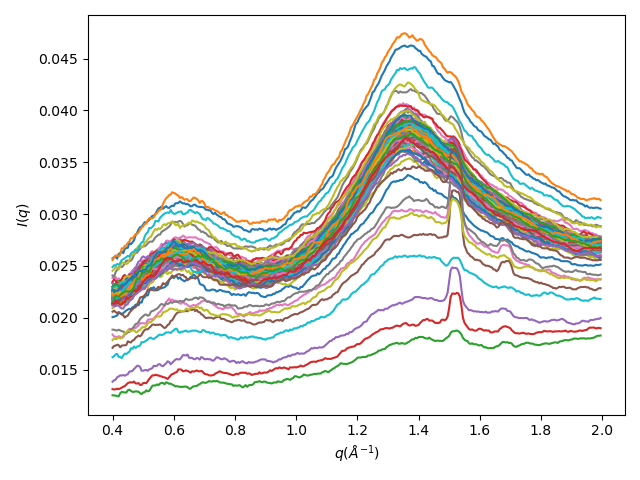

In [52]:
### plot particular frames for visualization
sys.path.insert(0, dataloader_path)
from lesions import get_dataframe_with_files_loc, XrayData
lidx = np.argmin(qgrid2 < 0.4)   # qvalue = 0.7,  idx = 190
uidx = np.argmin(qgrid2 < 2.0)   # qvalue = 1.46, idx = 342
tissue_sub = True ## True-tissue subtracted frames, False-no tissue subtraction


dataset     = XrayData(out.df, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=False, scaling=False, tissue_sub=tissue_sub).x

plt.close('all')
plt.figure()
plt.plot(qgrid2[lidx:uidx], dataset[np.arange(0,len(dataset)//40,1)].T )    # dataset[np.arange(0,len(dataset)//40,1)].T    dataset[[ 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1071, 1072]].T
plt.xlabel('$q(\AA^{-1})$')
plt.ylabel('$I(q)$')
plt.tight_layout()
plt.show()